In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

In [2]:
%reload_ext autoreload
%autoreload 2
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))
import Methodes.model_class as model_class

c:\Users\sliss\anaconda3\envs\PIR\lib\site-packages\gpflow\versions.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


On aura besoin de cette fonction pour visualiser nos sorties sous forme de gif (on pourra mettre en .mp4 si besoin)

In [3]:
#Enregistre un gif de la hauteur d'eau dans le dossier ./maps
def animate(map,title):
    T = map.shape[0]

    fig, ax = plt.subplots()
    img = ax.imshow(map[0], cmap="viridis", origin="lower")
    fig.colorbar(img, ax=ax, label="Hauteur d'eau (m)")
    ax.set_title("Hauteur d'eau, t=0")
    ax.set_xlabel("Z1")
    ax.set_ylabel("Z2")
    def update(frame):
        img.set_data(map[frame])
        ax.set_title(title+f", t={frame/6:.2f}")
        return img

    anim = FuncAnimation(fig, update, frames=T, interval=200, blit=False)
    anim.save(f"./output-GIF/maps_2/hauteur_eau_"+title+".gif", writer="imagemagick")
    plt.close(fig)   
    return None

### On souhaite maintenant avoir une **entrée fonctionnelle**, et en sortie une carte de la hauteur d'eau **au cours du temps**.

On importe notre plan d'expérience créé au préalable dans le notebook **Doe Functionnal**

In [4]:
T=36                  # On regarde toutes les 10 minutes pendant 6 heures, ca nous fait donc 36 points
t=np.linspace(0,6,T)
dt = t[1] - t[0] 

best_plan_values = np.load("./data_DoE/best_plan_values_2.npy")
test_values = np.load("./data_DoE/test_values_2.npy")

print("taille du jeu d'entrainement:",best_plan_values.shape)
print("taille du jeu de test:",test_values.shape)

taille du jeu d'entrainement: (200, 8, 36)
taille du jeu de test: (2000, 8, 36)


In [5]:
def Campbell(x,z1,z2):
  return x[0]*np.exp(-(0.8*z1+0.2*z2-10*x[1])**2/(60*x[0]**2))+(x[1]+x[3])*np.exp((0.5*z1+0.5*z2)*x[0]/500)+x[4]*(x[2]-2)*np.exp(-(0.4*z1+0.6*z2-20*x[5])**2/(40*x[4]**2))+(x[5]+x[7])*np.exp((0.3*z1+0.7*z2)*x[6]/250)

def Campbell_seuil(x,z1,z2,seuil):
  #np.maximum(Campbell(x,z1,z2)-seuil,0)
  return Campbell(x,z1,z2)*(Campbell(x,z1,z2)>=seuil)

On discrétise le domaine spatial.

In [6]:
n_grid = 64
D = n_grid**2
z1_vals=np.linspace(-90,90,n_grid)
z2_vals=np.linspace(-90,90,n_grid)

Z1,Z2=np.meshgrid(z1_vals,z2_vals)

On calcul à chaque pixel, et à chaque pas de temps la hauteur d'eau en utilisant la fonction Campbelle.

In [7]:
def Hauteur_Eau(e,Z1,Z2):
    vals = []
    for i in range(e.shape[1]):  
        vals.append(Campbell(e[:,i],Z1,Z2))  
    return np.array(vals)

def Hauteur_Eau_seuil(e,Z1,Z2,seuil):
    vals = []
    for i in range(e.shape[1]):  
        vals.append(Campbell_seuil(e[:,i],Z1,Z2,seuil))  
    return np.array(vals)

In [8]:
n_test = 2000
n_train = 200

x_test = test_values  # shape = (2000,8,36)
y_test = np.zeros((n_test,T*n_grid*n_grid))   # shape = (2000, 36*4096)

x_train = best_plan_values # shape = (200,8,36)
y_train = np.zeros((n_train,T*n_grid*n_grid))   # shape = (200, 36*4096)

#On calcul les sorties y avec le Simulateur
for i in range(n_train):
    ytrain_i = Hauteur_Eau(x_train[i], Z1, Z2)
    #ytrain_i = Hauteur_Eau_seuil(x_train[i], Z1, Z2, seuil=6.0)
    y_train[i,:] = ytrain_i.flatten()
for i in range(n_test):
    ytest_i = Hauteur_Eau(x_test[i], Z1, Z2)
    #ytest_i = Hauteur_Eau_seuil(x_test[i], Z1, Z2, seuil=6.0)
    y_test[i,:] = ytest_i.flatten()

On applique nos méthodes de prédiction:
- ACP classique
- B-spline et ACP
- Ondelettes et ACP (1D et 2D)


In [9]:
n_pc = 5  # On choisit arbitrairement le nombre de composantes principales (d'après la thèse, 5 semble un bon compromis)
theta = 3 # On choisit arbitrairement la valeur de theta 
sigma = 1 # et de sigma

In [10]:
#ACP -> pas de paramètres à choisir
#B-splines -> choix des noeuds
nombre_noeuds_spatiaux=9
txy = np.concatenate((
    np.repeat(-90, 2),                                      
    np.linspace(-90, 90, nombre_noeuds_spatiaux - 2)[1:-1],# noeuds internes
    np.repeat(90, 2)
))
nombre_noeuds_temporels=9
tt = np.concatenate((
    np.repeat(0, 2),
    np.linspace(0, 36, nombre_noeuds_temporels - 2)[1:-1],
    np.repeat(36, 2)
))
print("Les vecteur de noeuds utilisés pour la décompostion B-spline en spatial:",txy)
print("Le vecteur de noeuds utilisé pour la décompostion B-spline en temporel:",tt)
noeuds=[txy,txy,tt]
domaine=[z1_vals,z2_vals,t]
#Ondelettes -> choix du niveau de décomposition
p = 0.99999 #Il faut mettre un p quasiment égal à 1 pour obtenir un résultat satisfaisant

Les vecteur de noeuds utilisés pour la décompostion B-spline en spatial: [-90. -90. -60. -30.   0.  30.  60.  90.  90.]
Le vecteur de noeuds utilisé pour la décompostion B-spline en temporel: [ 0.  0.  6. 12. 18. 24. 30. 36. 36.]


Entrainement des modèles:

In [11]:
#ACP
print("-----------------ACP-----------------")
ACP = model_class.ACP_classique(n_pc,[theta,sigma])
ACP.train(x_train,y_train,verbose=False)

#B-spline
print("-----------------B-splines-----------------")
Bsplines = model_class.ACPF_Bsplines(n_pc,[theta,sigma],noeuds,domaine)
Bsplines.train(x_train,y_train,verbose=False)

#Ondelettes
print("-----------------Ondelettes-----------------")
Ondelettes = model_class.ACPF_Ondelettes(n_pc,[theta,sigma],p,2)
Ondelettes.train(x_train,y_train,verbose=False)


-----------------ACP-----------------

--- Entraînement du modèle GP pour la composante principale  1 ---
Modèle GP créé pour la composante principale  1 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  2 ---
Modèle GP créé pour la composante principale  2 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  3 ---
Modèle GP créé pour la composante principale  3 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  4 ---
Modèle GP créé pour la composante principale  4 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  5 ---
Modèle GP créé pour la composante principale  5 . Optimisation des hyperparamètres...
Optimisation terminée.
--- Analyse en Composantes Principales ---
Variance expliquée par les 5 premi

In [12]:
#Ondelettes 2D
print("-----------------Ondelettes 2D-----------------")
y_train_reshaped = y_train.reshape(n_train, T, n_grid, n_grid)
Ondelettes2D = model_class.ACPF_Ondelettes2D(n_pc,[theta,sigma],p,J=2)
Ondelettes2D.train(x_train,y_train_reshaped,verbose=False)

-----------------Ondelettes 2D-----------------
Nombre de coefficients conservés pour l'ACP : 62976
(200, 62976)

--- Entraînement du modèle GP pour la composante principale  1 ---
Modèle GP créé pour la composante principale  1 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  2 ---
Modèle GP créé pour la composante principale  2 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  3 ---
Modèle GP créé pour la composante principale  3 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  4 ---
Modèle GP créé pour la composante principale  4 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  5 ---
Modèle GP créé pour la composante principale  5 . Optimisation des hyperparamètres...
Optimisation terminée.
--

Prédiction:

In [13]:
Y_test_reconstruct_ACP      = ACP.predict(x_test)
Y_test_reconstruct_Bsplines = Bsplines.predict(x_test)
Y_test_reconstruct_wavelet  = Ondelettes.predict(x_test)

Prédiction en cours...
Prédiction en cours...
Prédiction en cours...


In [14]:
Y_test_reconstruct_wavelet2D = Ondelettes2D.predict(x_test)
Y_test_reconstruct_wavelet2D_reshaped = Y_test_reconstruct_wavelet2D.reshape(n_test, T, n_grid, n_grid)

Prédiction en cours...


MemoryError: Unable to allocate 2.20 GiB for an array with shape (2000, 64, 2304) and data type float64

On redimensionne nos sorties pour revenir aux dimensions : (n_test,T,n_grid,n_grid)

In [13]:
y_test_reshaped  = y_test.reshape(2000, 36, 64, 64)

y_test_reconstruct_ACP_reshaped = Y_test_reconstruct_ACP.reshape(2000, 36, 64, 64)
Y_test_reconstruct_Bsplines_reshaped = Y_test_reconstruct_Bsplines.reshape(2000, 36, 64, 64)
Y_test_reconstruct_wavelet_reshaped = Y_test_reconstruct_wavelet.reshape(2000, 36, 64, 64)

print("shape des y:",y_test.shape)
print("shape des y_reshaped:",y_test_reshaped.shape)

shape des y: (2000, 147456)
shape des y_reshaped: (2000, 36, 64, 64)


On va chercher à calculer l'erreur. Cependant on ne peut plus calculer de carte RMSE comme avant, car on a maintenant la dépendance temporelle.  
On peut faire :
- Erreur L² globale
- RMSE globale
- RMSE par test
- RMSE par pas de temps
- RMSE par position sur la grille

In [14]:
def compute_errors(Y_true, Y_pred,verbose=False):
    diff = Y_pred - Y_true
    RMSE_global = np.sqrt(np.mean(diff**2)) # Erreur L2 x L2
    RMSE_per_time = np.sqrt(np.mean(diff**2, axis=(0,2,3)))
    RMSE_per_grid = np.sqrt(np.mean(diff**2, axis=(0,1)))
    L_inf_L2_global = np.max(np.sqrt(np.sum(diff**2, axis=(2,3))))
    L2_L_inf_global = np.sqrt(np.mean((np.max(np.abs(diff), axis=(2,3)))))

    if verbose:
        print("RMSE global",RMSE_global.shape)
        print("RMSE per time",RMSE_per_time.shape)
        print("RMSE per grid",RMSE_per_grid.shape)
        print("L_inf of L2 global",L_inf_L2_global.shape)
        print("L2 of L_inf global",L2_L_inf_global.shape)
    return RMSE_global, RMSE_per_time, RMSE_per_grid, L_inf_L2_global, L2_L_inf_global

ACP_RMSE      , ACP_RMSE_time      , ACP_RMSE_grid   , ACP_L_inf_L2_global, ACP_L2_L_inf_global    = compute_errors(y_test_reshaped, y_test_reconstruct_ACP_reshaped,verbose=True)
B_splines_RMSE, B_splines_RMSE_time, B_splines_RMSE_grid , B_splines_L_inf_L2_global, B_splines_L2_L_inf_global = compute_errors(y_test_reshaped, Y_test_reconstruct_Bsplines_reshaped)
wavelet_RMSE  , wavelet_RMSE_time  , wavelet_RMSE_grid , wavelet_L_inf_L2_global, wavelet_L2_L_inf_global  = compute_errors(y_test_reshaped, Y_test_reconstruct_wavelet_reshaped)


RMSE global ()
RMSE per time (36,)
RMSE per grid (64, 64)
L_inf of L2 global ()
L2 of L_inf global ()


Erreur L-inf x L2:
ACP: 686.4326506810402   B-splines: 766.2410173280515   Ondelettes: 686.4334133545476
Erreur L2 x L-inf (normalisée):
ACP: 2.489176056662284   B-splines: 2.9892122013222453   Ondelettes: 2.489188317452815
Erreur L2 x L2 (normalisée):
ACP: 2.9293271406657384   B-splines: 4.218415695494965   Ondelettes: 2.92932773823292
On regarde la RMSE à chaque pas de temps


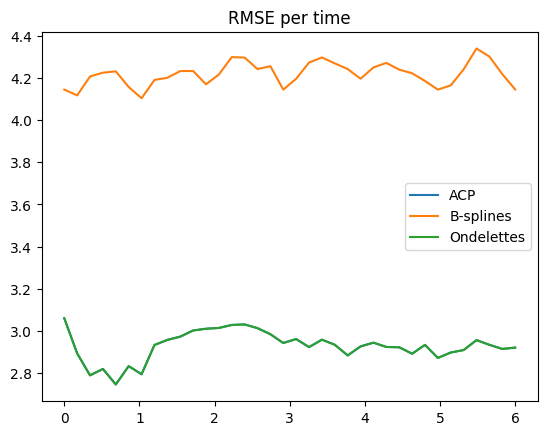

On regarde la RMSE à chaque pixel


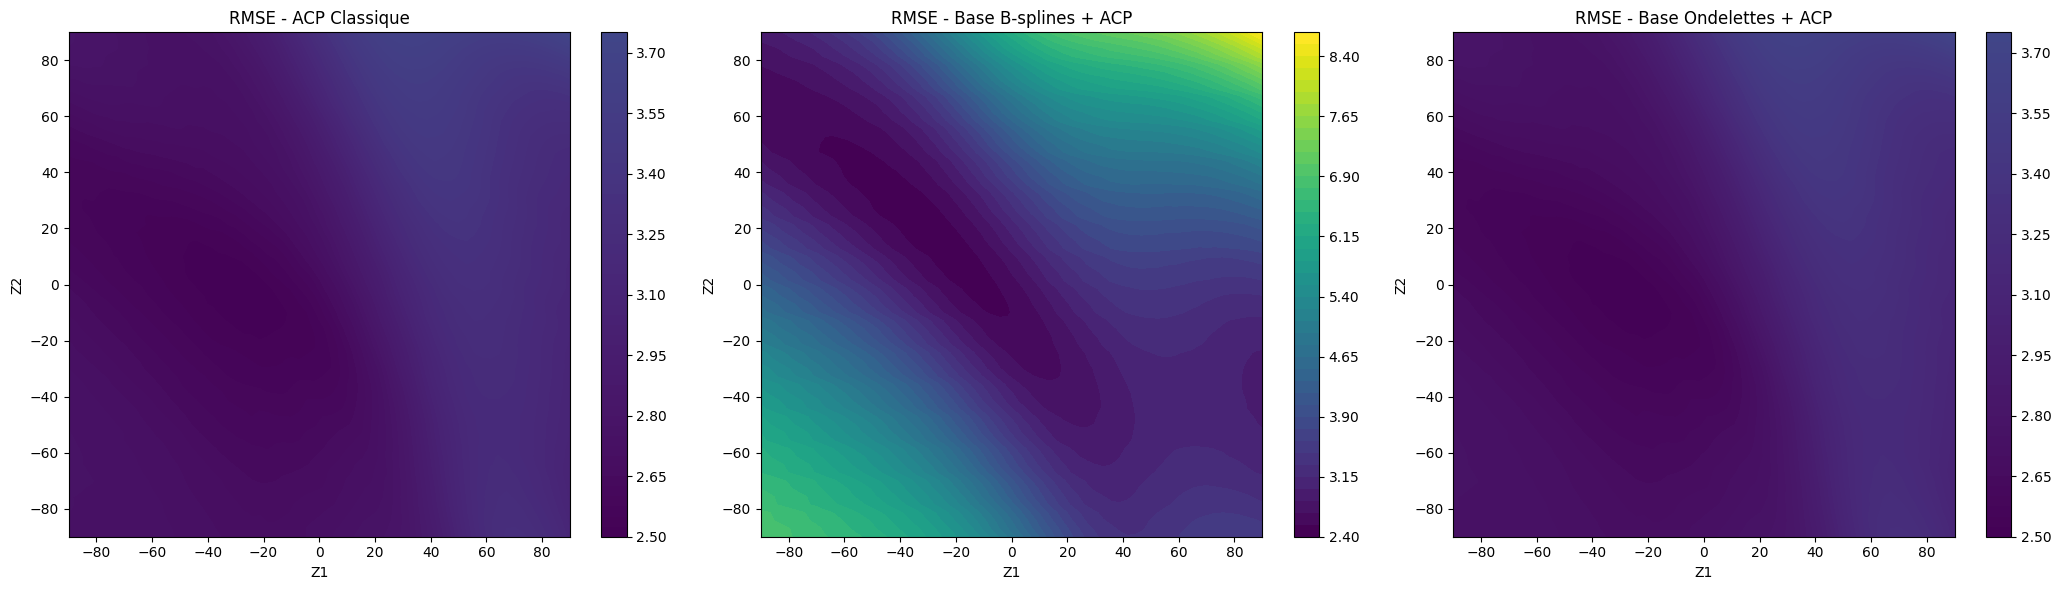

In [15]:
print("Erreur L-inf x L2:")
print("ACP:",ACP_L_inf_L2_global,"  B-splines:",B_splines_L_inf_L2_global,"  Ondelettes:",wavelet_L_inf_L2_global)

print("Erreur L2 x L-inf (normalisée):")
print("ACP:",ACP_L2_L_inf_global,"  B-splines:",B_splines_L2_L_inf_global,"  Ondelettes:",wavelet_L2_L_inf_global)

print("Erreur L2 x L2 (normalisée):")
print("ACP:",ACP_RMSE,"  B-splines:",B_splines_RMSE,"  Ondelettes:",wavelet_RMSE)

print("On regarde la RMSE à chaque pas de temps")
plt.plot(t,ACP_RMSE_time,label="ACP")
plt.plot(t,B_splines_RMSE_time,label="B-splines")
plt.plot(t,wavelet_RMSE_time,label="Ondelettes")
plt.title("RMSE per time")
plt.legend()
plt.show()

print("On regarde la RMSE à chaque pixel")
# --- Trouver les min/max communs pour la même échelle colorimétrique
vmin = min(ACP_RMSE_grid.min(), B_splines_RMSE_grid.min(), wavelet_RMSE_grid.min())
vmax = max(ACP_RMSE_grid.max(), B_splines_RMSE_grid.max(), wavelet_RMSE_grid.max())

# --- Plot côte à côte
plt.figure(figsize=(21, 6))

# ACP classique
plt.subplot(1, 3, 1)
contour1 = plt.contourf(Z1, Z2, ACP_RMSE_grid, levels=50,vmin = vmin, vmax=vmax)
plt.colorbar(contour1)
plt.title("RMSE - ACP Classique")
plt.xlabel("Z1")
plt.ylabel("Z2")

# ACP + B-splines
plt.subplot(1, 3, 2)
contour2 = plt.contourf(Z1, Z2, B_splines_RMSE_grid, levels=50,vmin = vmin, vmax=vmax)
plt.colorbar(contour2)
plt.title("RMSE - Base B-splines + ACP")
plt.xlabel("Z1")
plt.ylabel("Z2")

# ACP + Ondelettes
plt.subplot(1, 3, 3)
contour3 = plt.contourf(Z1, Z2, wavelet_RMSE_grid, levels=50,vmin = vmin, vmax=vmax)
plt.colorbar(contour3)
plt.title("RMSE - Base Ondelettes + ACP")
plt.xlabel("Z1")
plt.ylabel("Z2")

plt.tight_layout()
plt.show()

La méthode B-splines n'est plus adaptée. Il faut la modifié car maintenant on est en dimension 3 !

On peut regarder ce que ca donne pour une entrée i avec la méthode ACP.  
On va créer dans le dossier **./maps** 3 gifs : 
- La vraie sortie : *hauteur_eau_relle_i.gif*
- La sortie reconstruite : *hauteur_eau_reconstruite_i.gif*
- La différence : *hauteur_eau_erreur_i.gif*

In [15]:
i = np.random.choice(2000) # On regarde une entrée au hasard

vraie_sortie        = y_test_reshaped[i]
sortie_reconstruite = y_test_reconstruct_ACP_reshaped[i]
#Erreur relative SMAPE
#erreur = abs(vraie_sortie-sortie_reconstruite)/( (abs(vraie_sortie)+abs(sortie_reconstruite))/2 )
#Erreur relative
erreur = abs(vraie_sortie-sortie_reconstruite)/vraie_sortie #Probleme quand vraie_sortie est nulle

animate(vraie_sortie,f"réelle_{i}")
animate(sortie_reconstruite,f"reconstruite_{i}")
animate(erreur,f"erreur_{i}")

MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
